# Data Exploration

In [1]:
import pandas as pd
import numpy as np
shelter_df = pd.read_excel('dataset/processed/shelters_Feni.xlsx')
warehouse_df = pd.read_excel('dataset/processed/warehouses_Feni.xlsx')


In [2]:
# !pip install simpy
shelter_df.head()

,Unnamed: 0,ShelterNam,Capacity,Lat,Long,geometry,within_area,markersize
0,3361,Dakshin char dorbesh non gprs- cum-shelter,850,22.7991,91.3613,POINT (91.36133329228886 22.799094313320364),True,10.625
1,3374,Char Borodhali Health Complex,1000,22.8071,91.3865,POINT (91.38653656990846 22.807094493485376),True,12.500
2,3375,Rashadia cyclone shelter,1200,22.8084,91.3288,POINT (91.3288295012458 22.80839566480113),True,15.000
3,3380,Purba bara dhail gprs cum- shelter,950,22.8090,91.3822,POINT (91.38223604673483 22.808994733990435),True,11.875
4,3382,Paschim Char Darbesh Govt.Primary School,950,22.8103,91.3229,POINT (91.32292880755081 22.810295921261933),True,11.875


In [3]:
shelters = [f'S{i}' for i in range(1, len(shelter_df))]
print(shelter_df.geometry)
['S1', 'S2', 'S3', 'S4']

0     POINT (91.36133329228886 22.799094313320364)
1     POINT (91.38653656990846 22.807094493485376)
2       POINT (91.3288295012458 22.80839566480113)
3     POINT (91.38223604673483 22.808994733990435)
4     POINT (91.32292880755081 22.810295921261933)
                          ...                     
72    POINT (91.50015701540917 23.104216633187576)
73     POINT (91.49735672382084 23.10451670488479)
74     POINT (91.42684908741172 23.15242192670002)
75     POINT (91.42684908741172 23.15242192670002)
76    POINT (91.43785120116823 23.185624441148995)
Name: geometry, Length: 77, dtype: object


['S1', 'S2', 'S3', 'S4']

# Modeling

# Title of the model++

In [4]:
import geopandas as gpd
from shapely.geometry import Point

# Define your data: coordinates and optional attributes
data = {
    'Name': ['W1', 'W2'],
    'Latitude': [23.799094313320364, 22.899094313320364],
    'Longitude': [91.36133329228886, 91.28653656990846]  
}

# Create a GeoDataFrame
# Convert coordinates to Point objects
geometry = [Point(lon, lat) for lon, lat in zip(data['Longitude'], data['Latitude'])]
# Create the GeoDataFrame
warehouse_gdf = gpd.GeoDataFrame(data, geometry=geometry)
# Set the Coordinate Reference System (CRS) to WGS 84 (EPSG:4326)
warehouse_gdf.set_crs(epsg=4326, inplace=True)

shelters_Feni = gpd.read_file("dataset/processed/shelters_Feni/shelters_Feni.shp")
shelters_Feni.set_crs(epsg=4326, inplace=True) 
shelters_Feni['Name'] = [f'S{i}' for i in range(1, len(shelter_df)+1)]
shelters_location = [[point.x, point.y] for point in shelters_Feni.geometry]

gdf = gpd.GeoDataFrame(warehouse_gdf, geometry='geometry')
gdf.to_file("dataset/processed/warehouses_Feni/warehouses_Feni.shp")
warehouses_location = [[point.x, point.y] for point in warehouse_gdf.geometry]

In [5]:
from optimization_model.vrp_humanitarian import HumanitarianReliefVRP, ReliefNetwork
from scipy.spatial import distance_matrix
import re

# Define your data
warehouses = ['W1', 'W2']
#warehouse_locations = warehouse_df.geometry
#print(warehouse_locations)
#shelters = ['S1', 'S2', 'S3', 'S4']
shelters = [f'S{i}' for i in range(1, len(shelter_df)+1)]
# shelters_location = shelter_df.geometry



#distances = {('W1', 'S1'): 10, ('W1', 'S2'): 20, ('W1', 'S3'): 15, ('W1', 'S4'): 30,
#             ('W2', 'S1'): 25, ('W2', 'S2'): 30, ('W2', 'S3'): 20, ('W2', 'S4'): 10}

import math
def compute_distance(loc1, loc2):
    """
    Compute distance between two geolocations given their coordinates
    :param loc1: latitude and longitude of point 1
    :param loc2: latitude and longitude of point 2
    :return: Distance (possibly in kilometer) between two points  +++ great circle distance
    """
    dx = loc1[0] - loc2[0]
    dy = loc1[1] - loc2[1]
    return math.sqrt(dx * dx + dy * dy)

distance = {(f'W{w+1}', f'S{s+1}'): compute_distance(warehouses_location[w], shelters_location[s])
                    for w in range(len(warehouses_location)) for s in range(len(shelters_location))}
distance

{('W1', 'S1'): 1.0,
 ('W1', 'S2'): 0.9923199321566697,
 ('W1', 'S3'): 0.9912317128754553,
 ('W1', 'S4'): 0.990320201819962,
 ('W1', 'S5'): 0.9895439174616426,
 ('W1', 'S6'): 0.9857275490620606,
 ('W1', 'S7'): 0.9826986202935123,
 ('W1', 'S8'): 0.9827031308003591,
 ('W1', 'S9'): 0.9801362837993935,
 ('W1', 'S10'): 0.97380782581537,
 ('W1', 'S11'): 0.9742421655904724,
 ('W1', 'S12'): 0.9742522994093895,
 ('W1', 'S13'): 0.9741524147745713,
 ('W1', 'S14'): 0.972002722316959,
 ('W1', 'S15'): 0.9645863522499256,
 ('W1', 'S16'): 0.9631760425675631,
 ('W1', 'S17'): 0.963070823840773,
 ('W1', 'S18'): 0.9595285685627158,
 ('W1', 'S19'): 0.9595285685627158,
 ('W1', 'S20'): 0.9573048075015161,
 ('W1', 'S21'): 0.9573823656850523,
 ('W1', 'S22'): 0.9578668407573823,
 ('W1', 'S23'): 0.955718875407406,
 ('W1', 'S24'): 0.9541678309304064,
 ('W1', 'S25'): 0.951941553563984,
 ('W1', 'S26'): 0.9524513789381341,
 ('W1', 'S27'): 0.9511928735834662,
 ('W1', 'S28'): 0.9475370268703366,
 ('W1', 'S29'): 0.94510

In [6]:
drones = ['D1', 'D2']
trucks = ['T1', 'T2']
vehicles = drones + trucks

demands = {shelters[i]: shelter_df.loc[i, 'Capacity'] for i in range(len(shelters))} # need to create more accurate data based on World Food Program (WFP)


capacities = {'D1': 100, 'D2': 500, 'T1': 1600, 'T2': 2000}
ranges = {'D1': 25, 'D2': 25, 'T1': 50, 'T2': 50} # check the distance matrix (model could be infeasible)
population =  {shelters[i]: int(shelter_df.loc[i, 'Capacity']*0.9) for i in range(len(shelters))} # assuming 90% of capacity of that shelter
print(population)

{'S1': 765, 'S2': 900, 'S3': 1080, 'S4': 855, 'S5': 855, 'S6': 765, 'S7': 630, 'S8': 742, 'S9': 630, 'S10': 855, 'S11': 855, 'S12': 742, 'S13': 855, 'S14': 765, 'S15': 630, 'S16': 855, 'S17': 742, 'S18': 855, 'S19': 855, 'S20': 855, 'S21': 540, 'S22': 135, 'S23': 1822, 'S24': 1080, 'S25': 1350, 'S26': 540, 'S27': 630, 'S28': 855, 'S29': 855, 'S30': 855, 'S31': 855, 'S32': 855, 'S33': 1620, 'S34': 855, 'S35': 1080, 'S36': 765, 'S37': 855, 'S38': 742, 'S39': 630, 'S40': 855, 'S41': 855, 'S42': 630, 'S43': 742, 'S44': 855, 'S45': 855, 'S46': 540, 'S47': 540, 'S48': 630, 'S49': 630, 'S50': 1620, 'S51': 1350, 'S52': 900, 'S53': 630, 'S54': 855, 'S55': 472, 'S56': 1350, 'S57': 652, 'S58': 630, 'S59': 630, 'S60': 652, 'S61': 630, 'S62': 1350, 'S63': 652, 'S64': 1350, 'S65': 1350, 'S66': 1350, 'S67': 1350, 'S68': 1350, 'S69': 652, 'S70': 1350, 'S71': 1350, 'S72': 630, 'S73': 1350, 'S74': 378, 'S75': 1350, 'S76': 1350, 'S77': 1350}


In [7]:
# Instantiate and solve the optimization model
vrp_model = HumanitarianReliefVRP(warehouses, shelters, vehicles, distance, demands, capacities, ranges, population)
vrp_model.build_model()
vrp_model.solve()


Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-03
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 93 rows, 693 columns and 1925 nonzeros
Model fingerprint: 0xbb97ce28
Variable types: 0 continuous, 693 integer (693 binary)
Coefficient statistics:
  Matrix range     [6e-02, 2e+03]
  Objective range  [1e+02, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 2e+03]
Found heuristic solution: objective -0.0000000
Presolve removed 15 rows and 327 columns
Presolve time: 0.00s
Presolved: 78 rows, 366 columns, 658 nonzeros
Found heuristic solution: objective 6363.0000000
Variable types: 0 continuous, 366 integer (366 binary)

Root relaxation: objective 6.993000e+03, 120 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Wor

pos-------- {'W1': array([91.36133329, 23.79909431]), 'S2': array([91.38653657, 22.80709449]), 'S21': array([91.37413578, 22.84179755]), 'S22': array([91.4021393 , 22.84209705]), 'S26': array([91.40613985, 22.84769744]), 'S58': array([91.38163872, 22.93640513]), 'S61': array([91.57096272, 22.96180369]), 'W2': array([91.28653657, 22.89909431]), 'S9': array([91.36993474, 22.81899577]), 'S46': array([91.36123518, 22.88750151]), 'S47': array([91.44594579, 22.89260036]), 'S52': array([91.4602481 , 22.91930228]), 'S53': array([91.46074817, 22.91980231]), 'S74': array([91.49735672, 23.1045167 ])}


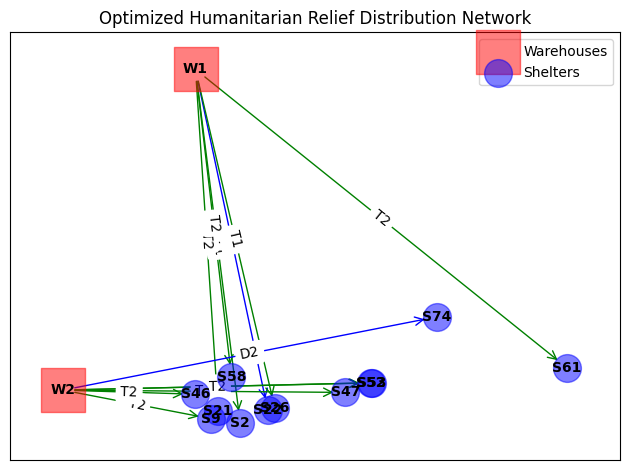

In [8]:
# Get the optimized routes
routes = vrp_model.get_routes()
# Extract coordinates from GeoDataFrame and create a dictionary
node_positions1 = {row['Name']: np.array([row['geometry'].x, row['geometry'].y]) for idx, row in warehouse_gdf.iterrows()}
node_positions2= {row['Name']: np.array([row['geometry'].x, row['geometry'].y])  for idx, row in shelters_Feni.iterrows()}
# for node_id, coord in zip(node_ids, coordinates)
node_positions0 = {**node_positions1, **node_positions2} #node_positions1.update(node_positions2)
keys_to_keep = [key for sublist in routes for key in sublist]
# Filter the dictionary to keep only the keys in `keys_to_keep`
node_positions = {k: node_positions0[k] for k in keys_to_keep if k in node_positions0}


# Instantiate and plot the network
relief_network = ReliefNetwork(warehouses_location, shelters_location, node_positions, demands)
relief_network.add_routes(routes)
relief_network.plot_network()

# Application